# YouTube Spam Detection

In [1]:
# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, month, to_date
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Step 1: Initialize Spark Session

In [2]:
spark = SparkSession.builder.appName("YouTubeSpamDetection-Master").getOrCreate()

25/05/07 17:20:19 WARN Utils: Your hostname, Preets-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 130.85.247.147 instead (on interface en0)
25/05/07 17:20:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/07 17:20:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Step 2: Load Dataset

In [3]:

files = ["Youtube01-Psy.csv", "Youtube02-KatyPerry.csv", "Youtube03-LMFAO.csv", "Youtube04-Eminem.csv", "Youtube05-Shakira.csv"]

df = spark.read.csv(files[0], header=True, inferSchema=True)
for file in files[1:]:
    df_next = spark.read.csv(file, header=True, inferSchema=True)
    df = df.union(df_next)

df.printSchema()
df.show(10)


root
 |-- COMMENT_ID: string (nullable = true)
 |-- AUTHOR: string (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- CONTENT: string (nullable = true)
 |-- CLASS: string (nullable = true)

+--------------------+----------------+-------------------+--------------------+-----+
|          COMMENT_ID|          AUTHOR|               DATE|             CONTENT|CLASS|
+--------------------+----------------+-------------------+--------------------+-----+
|LZQPQhLyRh80UYxNu...|       Julius NM|2013-11-07 06:20:48|Huh, anyway check...|    1|
|LZQPQhLyRh_C2cTtd...|     adam riyati|2013-11-07 12:37:15|Hey guys check ou...|    1|
|LZQPQhLyRh9MSZYnf...|Evgeny Murashkin|2013-11-08 17:34:21|just for test I h...|    1|
|z13jhp0bxqncu512g...| ElNino Melendez|2013-11-09 08:28:43|me shaking my sex...|    1|
|z13fwbwp1oujthgqj...|          GsMega|2013-11-10 16:05:38|watch?v=vtaRGgvGt...|    1|
|LZQPQhLyRh9-wNRtl...|    Jason Haddad|2013-11-26 02:55:11|Hey, check out my...|    1|
|z13lfzdo5vmdi1c

## Step 3: Check CLASS Column for Impurities

In [4]:

df.select("CLASS").distinct().show()

+--------------------+
|               CLASS|
+--------------------+
| There's No Point...|
|                   0|
| made with Fruity...|
|                   1|
| ""DECIO HAIR"". ...|
| you guys will be...|
| Help Rand Protec...|
|                NULL|
+--------------------+



## Step 4: Clean CLASS Column

In [5]:

df = df.withColumn("CLASS", col("CLASS").cast(IntegerType()))
df_clean = df.na.drop(subset=["CLASS"])
df_clean.select("CLASS").distinct().show()


+-----+
|CLASS|
+-----+
|    1|
|    0|
+-----+



## Step 5: EDA - Total Count and Null Values

In [6]:

print("Total Records after cleaning:", df_clean.count())
df_clean.select([col(c).isNull().alias(c) for c in df_clean.columns]).groupBy().sum().show()


Total Records after cleaning: 1955
++
||
++
||
++



## Step 6: Spam vs Ham Distribution (Pie Chart)

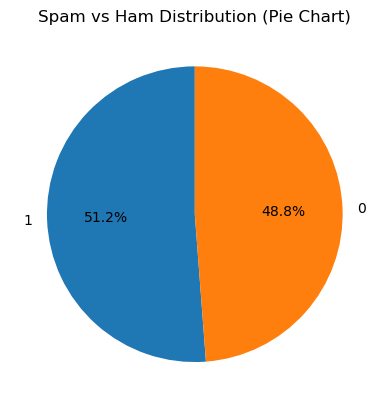

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [7]:

df_class_dist = df_clean.groupBy("CLASS").count().toPandas()

plt.pie(df_class_dist['count'], labels=df_class_dist['CLASS'], autopct='%1.1f%%', startangle=90)
plt.title("Spam vs Ham Distribution (Pie Chart)")
plt.show()
plt.figure(figsize=(10, 6))

## Step 7: Frequent Commenters

In [8]:

df_clean.groupBy("AUTHOR").count().orderBy("count", ascending=False).show(10)


+----------------+-----+
|          AUTHOR|count|
+----------------+-----+
|           M.E.S|    8|
|    Louis Bryant|    7|
| Shadrach Grentz|    7|
|        5000palo|    7|
|        DanteBTV|    6|
|  LuckyMusiqLive|    5|
|      Derek Moya|    5|
|     Hidden Love|    5|
|   AllDailyVines|    4|
|RapStarz Coleman|    4|
+----------------+-----+
only showing top 10 rows



## Step 8: Monthly Comment Trend

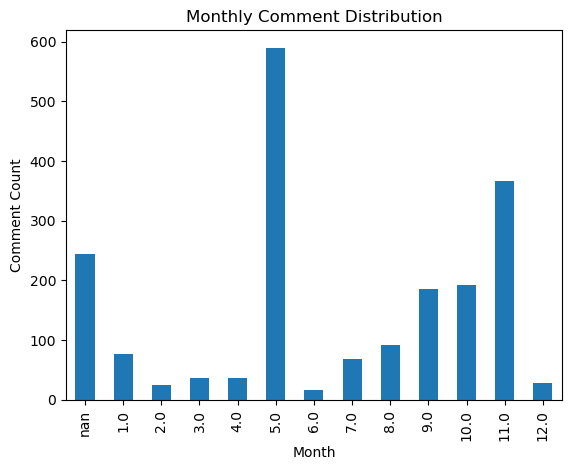

In [9]:

df_with_date = df_clean.withColumn("date_only", to_date(col("DATE")))
df_with_month = df_with_date.withColumn("month", month(col("date_only")))
monthly_dist = df_with_month.groupBy("month").count().orderBy("month").toPandas()

monthly_dist.plot(kind="bar", x="month", y="count", legend=False)
plt.title("Monthly Comment Distribution")
plt.xlabel("Month")
plt.ylabel("Comment Count")
plt.show()


## Step 9: Monthly Spam vs Ham Distribution

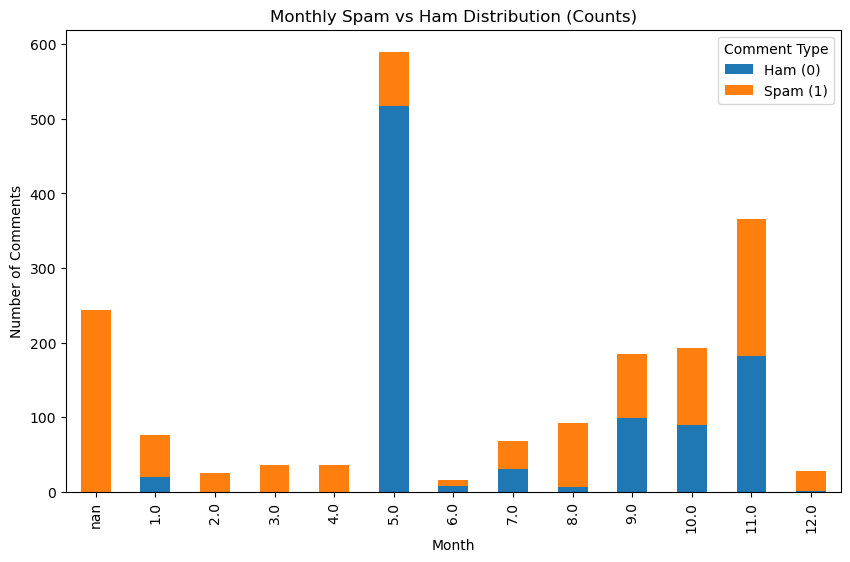

In [10]:

df_with_month_class = df_with_date.withColumn("month", month(col("date_only")))
monthly_class_dist = df_with_month_class.groupBy("month", "CLASS").count().orderBy("month").toPandas()

pivot_data = monthly_class_dist.pivot(index='month', columns='CLASS', values='count').fillna(0)
pivot_data.columns = ['Ham (0)', 'Spam (1)']

pivot_data.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Monthly Spam vs Ham Distribution (Counts)")
plt.xlabel("Month")
plt.ylabel("Number of Comments")
plt.legend(title="Comment Type")
plt.show()

# pivot_percent = pivot_data.div(pivot_data.sum(axis=1), axis=0)
# pivot_percent.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
# plt.title("Monthly Spam vs Ham Distribution (Percentage)")
# plt.xlabel("Month")
# plt.ylabel("Percentage")
# plt.legend(title="Comment Type")
# plt.show()


## Step 10: Text Preprocessing

In [11]:

df_preprocessed = df_clean.select("CONTENT", "CLASS")
df_preprocessed = df_preprocessed.withColumn("CONTENT", lower(col("CONTENT")))
df_preprocessed = df_preprocessed.withColumn("CONTENT", regexp_replace(col("CONTENT"), r"http\S+|www\S+|https\S+", "URL"))
df_preprocessed = df_preprocessed.withColumn("CONTENT", regexp_replace(col("CONTENT"), r"[^a-zA-Z\s]", ""))
df_preprocessed = df_preprocessed.withColumn("CONTENT", regexp_replace(col("CONTENT"), r"\s+", " "))

df_preprocessed.show(5)


+--------------------+-----+
|             CONTENT|CLASS|
+--------------------+-----+
|huh anyway check ...|    1|
|hey guys check ou...|    1|
|just for test i h...|    1|
|me shaking my sex...|    1|
|watchvvtarggvgtwq...|    1|
+--------------------+-----+
only showing top 5 rows



## Step 11: Feature Extraction

In [12]:

tokenizer = Tokenizer(inputCol="CONTENT", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="features", numFeatures=1000)

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf])
pipeline_model = pipeline.fit(df_preprocessed)
df_features = pipeline_model.transform(df_preprocessed)

df_features.select("CONTENT", "filtered_words", "features", "CLASS").show(5)


+--------------------+--------------------+--------------------+-----+
|             CONTENT|      filtered_words|            features|CLASS|
+--------------------+--------------------+--------------------+-----+
|huh anyway check ...|[huh, anyway, che...|(1000,[132,429,51...|    1|
|hey guys check ou...|[hey, guys, check...|(1000,[216,314,33...|    1|
|just for test i h...|[test, say, murde...|(1000,[428,586,86...|    1|
|me shaking my sex...|[shaking, sexy, a...|(1000,[37,467,592...|    1|
|watchvvtarggvgtwq...|[watchvvtarggvgtw...|(1000,[228,901],[...|    1|
+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



## Step 12: Train Test Split

In [13]:

total_count = df_features.count()
class_counts = df_features.groupBy("CLASS").count().collect()

fractions = {}
for row in class_counts:
    fractions[row["CLASS"]] = 0.8

train_data = df_features.sampleBy("CLASS", fractions=fractions, seed=42)
test_data = df_features.subtract(train_data)

train_data.groupBy("CLASS").count().show()
test_data.groupBy("CLASS").count().show()

+-----+-----+
|CLASS|count|
+-----+-----+
|    1|  799|
|    0|  773|
+-----+-----+

+-----+-----+
|CLASS|count|
+-----+-----+
|    1|  136|
|    0|  162|
+-----+-----+



## Step 13: Train and Evaluate Models - Naive Bayes

In [14]:
# Train the model
nb = NaiveBayes(featuresCol="features", labelCol="CLASS")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# Evaluate metrics
evaluator = MulticlassClassificationEvaluator(labelCol="CLASS", predictionCol="prediction")

nb_accuracy = evaluator.evaluate(nb_predictions, {evaluator.metricName: "accuracy"})
nb_precision = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedPrecision"})
nb_recall = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedRecall"})
nb_f1 = evaluator.evaluate(nb_predictions, {evaluator.metricName: "f1"})

print("Naive Bayes Metrics:")
print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1 Score: {nb_f1}")

# Visualization: Mini heatmap for Naive Bayes metrics

# nb_metrics = pd.DataFrame({
#     "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
#     "Value": [nb_accuracy, nb_precision, nb_recall, nb_f1]
# }).set_index("Metric")

# sns.heatmap(nb_metrics, annot=True, cmap="Blues", vmin=0, vmax=1)
# plt.title("Naive Bayes - Metrics Heatmap")
# plt.show()


25/05/07 17:20:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/07 17:20:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Naive Bayes Metrics:
Accuracy: 0.8859060402684564
Precision: 0.8861103005544209
Recall: 0.8859060402684564
F1 Score: 0.8859681125138561


### Logistic Regression

In [15]:
#Train Model
lr = LogisticRegression(featuresCol="features", labelCol="CLASS")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluate metrics
evaluator = MulticlassClassificationEvaluator(labelCol="CLASS", predictionCol="prediction")

lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})
lr_f1 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})

print("Logistic Regression Metrics:")
print(f"Accuracy: {lr_accuracy}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1}")


Logistic Regression Metrics:
Accuracy: 0.802013422818792
Precision: 0.8017703002724508
Recall: 0.802013422818792
F1 Score: 0.8016640731897597


### Decision Tree

In [16]:
#Train Model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="CLASS")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate metrics
evaluator = MulticlassClassificationEvaluator(labelCol="CLASS", predictionCol="prediction")

dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})
dt_f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

print("Decision Tree Metrics:")
print(f"Accuracy: {dt_accuracy}")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")
print(f"F1 Score: {dt_f1}")


25/05/07 17:20:35 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Decision Tree Metrics:
Accuracy: 0.8389261744966443
Precision: 0.8528067103449377
Recall: 0.8389261744966443
F1 Score: 0.8354271925194179


### Random Forest

In [17]:

#Train Model
rf = RandomForestClassifier(featuresCol="features", labelCol="CLASS", numTrees=20)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate metrics
evaluator = MulticlassClassificationEvaluator(labelCol="CLASS", predictionCol="prediction")

rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
rf_f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

print("Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")


Random Forest Metrics:
Accuracy: 0.8657718120805369
Precision: 0.8688485031294775
Recall: 0.8657718120805369
F1 Score: 0.8647354915120411


## Step 14: Compare Model Accuracies

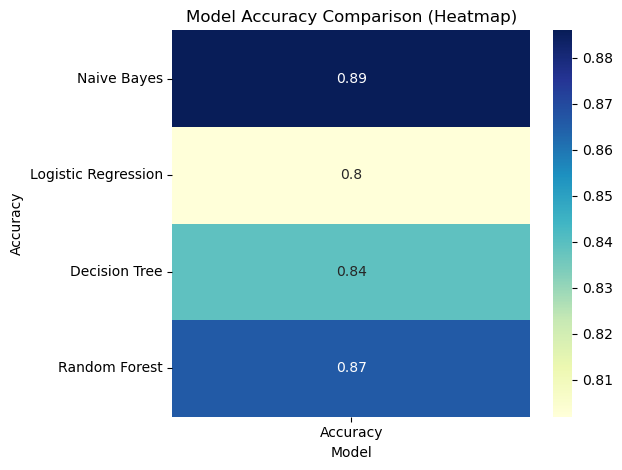

In [18]:

metrics_data = {
    'Model': ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [nb_accuracy, lr_accuracy, dt_accuracy, rf_accuracy]
}

metrics_df = pd.DataFrame(metrics_data).set_index("Model")

sns.heatmap(metrics_df, annot=True, cmap="YlGnBu")
plt.title("Model Accuracy Comparison (Heatmap)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
#plt.xticks(rotation=45)
#plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Step 15: Scalability Test - Executor (CPU Core) Scaling

In [19]:
results = {}

for cores in [1, 2, 4]:
    master = f"local[{cores}]"
    print(f"\nRunning with Spark Master: {master}")

    spark = SparkSession.builder.master(master).appName("ExecutorScalingTest").getOrCreate()
    
    start = time.time()

    # Load Data
    files = ["Youtube01-Psy.csv", "Youtube02-KatyPerry.csv", "Youtube03-LMFAO.csv", "Youtube04-Eminem.csv", "Youtube05-Shakira.csv"]
    df = spark.read.csv(files[0], header=True, inferSchema=True)
    for file in files[1:]:
        df = df.union(spark.read.csv(file, header=True, inferSchema=True))

    # Clean CLASS column
    df = df.withColumn("CLASS", col("CLASS").cast(IntegerType()))
    df = df.na.drop(subset=["CLASS"])

    # Preprocessing
    df = df.withColumn("CONTENT", lower(col("CONTENT")))
    df = df.withColumn("CONTENT", regexp_replace(col("CONTENT"), r"http\\S+|www\\S+|https\\S+", "URL"))
    df = df.withColumn("CONTENT", regexp_replace(col("CONTENT"), r"[^a-zA-Z\\s]", ""))
    df = df.withColumn("CONTENT", regexp_replace(col("CONTENT"), r"\\s+", " "))

    tokenizer = Tokenizer(inputCol="CONTENT", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="features", numFeatures=1000)

    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF])
    model = pipeline.fit(df)
    df_features = model.transform(df)

    train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

    nb = NaiveBayes(featuresCol="features", labelCol="CLASS")
    nb_model = nb.fit(train_data)
    predictions = nb_model.transform(test_data)
    
    end = time.time()
    elapsed = end - start
    print(f"Total Time Taken with {master}: {elapsed:.2f} seconds\n")

    spark.stop()
    results[master] = elapsed


Running with Spark Master: local[1]


25/05/07 17:20:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Total Time Taken with local[1]: 0.74 seconds


Running with Spark Master: local[2]
Total Time Taken with local[2]: 0.65 seconds


Running with Spark Master: local[4]
Total Time Taken with local[4]: 0.56 seconds



  Spark Master  Execution Time (s)
0     local[1]            0.742358
1     local[2]            0.645178
2     local[4]            0.555977


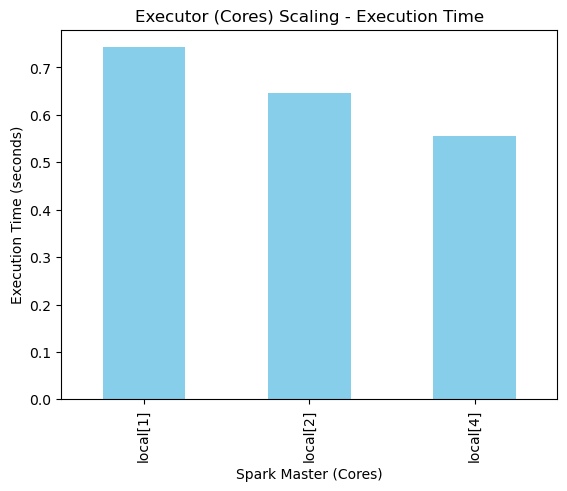

In [20]:
# Visualization of Results
df_results = pd.DataFrame(list(results.items()), columns=["Spark Master", "Execution Time (s)"])
print(df_results)

# Plotting
df_results.plot(x="Spark Master", y="Execution Time (s)", kind="bar", legend=False, color="skyblue")
plt.title("Executor (Cores) Scaling - Execution Time")
plt.ylabel("Execution Time (seconds)")
plt.xlabel("Spark Master (Cores)")
plt.show()